# Global equilibrium method

© 2022 Exneyder A. Montoya-Araque, Daniel F. Ruiz and Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/EAFIT_slope_stability/blob/main/notebooks/03_rupture/global_equilibrium_method.ipynb).

## Required modules and initial setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import split
from ipywidgets import widgets as wgt
from IPython import get_ipython
from IPython.display import display

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    from subprocess import run
    run('pip install ipympl', shell=True);
    from google.colab import output
    output.enable_custom_widget_manager()

# %matplotlib widget
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman", "cmr", "cmr10", "DejaVu Serif"],  # or 
    "mathtext.fontset": "cm",  # Use Computer Modern fonts for math
    "axes.formatter.use_mathtext": True,  # Use mathtext for axis labels
    "axes.unicode_minus": False,   # Use standard minus sign instead of a unicode character
})

## Area and centroid of a mass sliding along a circular surface

### Funtions

In [2]:
def slope(height, inclination, hzt_dist):
    hzt_slope = height / np.tan(np.radians(inclination))  # horizontal dist. of slope face
    terrain_coords = ((hzt_dist, 0, -hzt_slope, -hzt_slope - hzt_dist),
                      (0, 0, height, height))
    return np.array(terrain_coords)

def get_geometric_parameters(terrain_coords, center_x, center_y, radius):
    slope_surf = LineString(terrain_coords.T)
    circle = Point(center_x, center_y).buffer(radius)
    split_circle = split(circle, slope_surf)
    if len(split_circle.geoms)==1:
        mass_polygon = split_circle.geoms[0]
        surface_line = mass_polygon.exterior
    else:
        split_circle_0_xy = split_circle.geoms[0].exterior.xy
        split_circle_1_xy = split_circle.geoms[1].exterior.xy
        if max(split_circle_0_xy[1]) > max(split_circle_1_xy[1]):
            mass_polygon = split_circle.geoms[1]
        else:
            mass_polygon = split_circle.geoms[0]
        surface_line = mass_polygon.exterior.difference(slope_surf.buffer(.001))
    return mass_polygon, surface_line


def plot_slope(height, inclination, center_x, center_y, radius, widget=False, **kwargs):
    hzt_slope = height / np.tan(np.radians(inclination))
    terrain_coords = slope(height, inclination, 1e9)
    mass_polygon, surface_line = get_geometric_parameters(
        terrain_coords, center_x, center_y, radius)
    hzt_dist = max(
        max(surface_line.xy[0]), abs(min(surface_line.xy[0]))-hzt_slope, 0.5*height)
    terrain_coords = slope(height, inclination, 1.2 * hzt_dist)
    # Figure
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=kwargs.get('figsize', [8, 4]))
    # ax.plot(terrain_coords[0], terrain_coords[1], "ok")
    # ax.plot(*mass_polygon.exterior.xy, ':y')
    ax.plot(terrain_coords[0], terrain_coords[1], "-k")
    ax.plot(*surface_line.xy, "#BB5566", ls="--",
            label=f"Slip surface \n$\cdot$Area: {mass_polygon.area:.2f} m$^2$ "
            +f"\n$\cdot$Length: {surface_line.length:.2f} m")
    ax.plot(center_x, center_y, color="black", marker="x", ls="",
        label=f"Center: $x=${center_x:.1f} m, $y=${center_y:.1f} m")
    ax.plot(*mass_polygon.centroid.xy, color="#004488", marker="o", ls="",
            label=f"Centroid: $x=${mass_polygon.centroid.x:.1f} m, "
            + f"$y=${mass_polygon.centroid.y:.1f} m")
    ax.set(xlabel="$x$ [m]", ylabel="$y$ [m]")
    ax.set_aspect("equal", "box")
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.legend(loc="center left", bbox_to_anchor=(1.01, 0.5))
    return

# plot_slope(height=18, inclination=45, center_x=-3.5, center_y=12, radius=15)
# plot_slope(height=8, inclination=45, center_x=-3.5, center_y=12, radius=11.4)

### Static figure

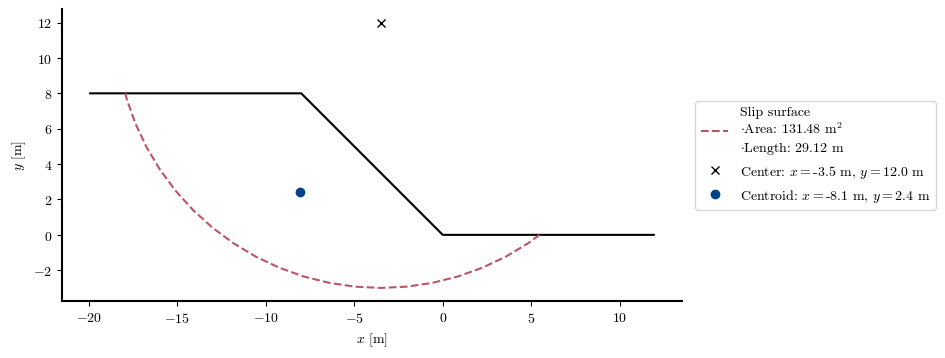

In [3]:
height = 8  # [m]
inclination = 45  # [°]
center_x = -3.5  # [m]
center_y = 12  # [m]
radius = 15  # [m]
plot_slope(height, inclination, center_x, center_y, radius)

### Interactive figure

In [4]:
s, l = {'description_width': '150'}, wgt.Layout(width='400px')
controls = {
    'height': wgt.FloatSlider(value=8, min=0.0, description="Height [m]", style=s, layout=l),
    'inclination': wgt.FloatSlider(value=45, min=0.5, max=90, description="Inclination [°]", style=s, layout=l),
    'center_x': wgt.FloatSlider(value=-3.5, min=-50, description="Center_𝑥 [m]", style=s, layout=l),
    'center_y': wgt.FloatSlider(value=12, min=0.1, description="Center_𝑦 [m]", style=s, layout=l),
    'radius': wgt.FloatSlider(value=15, min=0.1, description="Radius [m]", style=s, layout=l),
    'widget': wgt.Checkbox(value=True, description='Non-vector image (improve widget performance)', style=s, layout=l)
}
fig = wgt.interactive_output(plot_slope, controls)
wgt.HBox((wgt.VBox(list(controls.values())), fig), layout=wgt.Layout(align_items='center'))